In [91]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd, xgboost, numpy as np, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [92]:
df = pd.read_csv(r"D:\deep_learning\CNN\bbc-text.csv\bbc-text.csv")

In [93]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [94]:
df['category_id'] = df['category'].factorize()[0]
df['category_id'].shape

(2225,)

In [95]:
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')

In [96]:
category_id_df

,category,category_id
0,tech,0
1,business,1
2,sport,2
4,entertainment,3
5,politics,4


In [97]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [98]:
df.groupby('category').category_id.count()


category
business         510
entertainment    386
politics         417
sport            511
tech             401
Name: category_id, dtype: int64

In [99]:
tfidf = TfidfVectorizer(sublinear_tf =True, min_df =5, norm ='l2',encoding ='latin-1'
                       ,ngram_range =(1,2), stop_words ='english')

In [100]:
features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id

In [101]:
print(features.shape)
print(labels.shape)

(2225, 14415)
(2225,)


In [102]:
sorted(category_to_id.items())

[('business', 1),
 ('entertainment', 3),
 ('politics', 4),
 ('sport', 2),
 ('tech', 0)]

In [109]:
#use chi square analysis to find the corelation between
#features (importance of words) and labels(categories)
from sklearn.feature_selection import chi2

N=3 #We are going to look for top 3 categories
#For each category, find words that are highly corelated to it
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels==category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("'# '{}' :".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))
    

'# 'business' :
  . Most correlated unigrams:
       . oil
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . economic growth
       . stock market
'# 'entertainment' :
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
'# 'politics' :
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
'# 'sport' :
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
'# 'tech' :
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [110]:
features_chi2

(array([0.00355164, 0.29252643, 0.67297617, ..., 0.02810703, 0.13112208,
        0.17836794]),
 array([0.95247768, 0.58860607, 0.4120159 , ..., 0.86685744, 0.71727145,
        0.67277957]))

In [113]:
from sklearn.manifold import TSNE
SAMPLE_SIZE = int(len(features)*0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size =SAMPLE_SIZE, replace =False)

In [115]:
projected_features = TSNE(n_components =2, random_state =0).fit_transform(features[indices])

In [116]:
type(projected_features)

numpy.ndarray

In [117]:
my_id =0
projected_features[(labels[indices] == my_id).values]

array([[-14.018825  ,  -6.7191367 ],
       [ -8.161536  , -25.881407  ],
       [-11.838124  , -18.872372  ],
       [-10.348611  , -10.918498  ],
       [  2.4989889 ,  -8.323587  ],
       [ -7.14939   , -22.207441  ],
       [ -5.4628415 , -27.831844  ],
       [  5.326618  , -25.345383  ],
       [ -7.351507  , -17.378439  ],
       [-22.47762   , -21.586973  ],
       [-19.510622  , -33.20581   ],
       [ -3.5415826 , -21.971838  ],
       [-34.869495  ,  15.965835  ],
       [ -6.7658386 , -34.148117  ],
       [ -1.4630113 , -33.612988  ],
       [-10.320313  , -10.913226  ],
       [  2.1491542 , -22.109478  ],
       [  2.3681    , -30.179533  ],
       [ -5.835384  , -23.15683   ],
       [-15.154101  ,  -8.540079  ],
       [-12.362304  ,  -8.5292015 ],
       [-18.715155  , -32.488403  ],
       [ -5.759253  , -23.57361   ],
       [-12.704099  , -21.748663  ],
       [-13.8047905 , -21.13625   ],
       [-11.516552  , -26.683485  ],
       [-21.44197   , -26.66838   ],
 

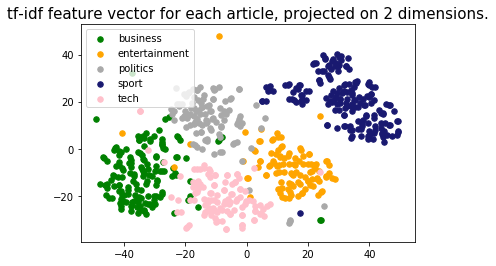

In [118]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [121]:
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

models = [RandomForestClassifier(n_estimators =200, max_depth =3, 
                                random_state= 42),
         MultinomialNB(),
         LogisticRegression(random_state=42),]

In [125]:
CV =5

cv_df = pd.DataFrame(index =range(cv*len(models)))
entries =[]

In [129]:
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model, features, labels, 
                                 scoring ='accuracy',cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [134]:
cv_df =pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [135]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.812500
1,RandomForestClassifier,1,0.844944
2,RandomForestClassifier,2,0.828829
3,RandomForestClassifier,3,0.817568
4,RandomForestClassifier,4,0.822072
5,MultinomialNB,0,0.970982
6,MultinomialNB,1,0.977528
7,MultinomialNB,2,0.979730
8,MultinomialNB,3,0.952703
9,MultinomialNB,4,0.972973


In [139]:
import seaborn as sns

#sns.boxplot(x='model_name', y ='accuracy', data ='cv_df')
sns.stripplot(x='model_name', y = 'accuracy', data ='cv_df',
            size =8, jitter=True, edgecolor ="blue", linewidth =2)

AttributeError: 'str' object has no attribute 'get'

In [142]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.979782
MultinomialNB             0.970783
RandomForestClassifier    0.825182
Name: accuracy, dtype: float64

In [144]:
from sklearn.model_selection import train_test_split
model = LogisticRegression()
X_train, X_test, y_train,y_test, indices_train, indices_test = train_test_split(features,
                                                   labels, df.index, test_size =0.33, random_state =42)

In [151]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [152]:
y_pred_proba

array([[0.04629375, 0.08382582, 0.06803685, 0.05191286, 0.74993071],
       [0.09807159, 0.65293625, 0.08773593, 0.07677152, 0.08448471],
       [0.05019315, 0.05835423, 0.08101308, 0.76736191, 0.04307762],
       ...,
       [0.09617858, 0.09654262, 0.61298588, 0.09575343, 0.09853949],
       [0.03321871, 0.03757005, 0.0519669 , 0.04708277, 0.83016157],
       [0.067189  , 0.06134381, 0.72982655, 0.08054024, 0.06110041]])

In [154]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
#sns.heatmap(conf_mat, annot=True, fmt='d',
#            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
#plt.ylabel('Actual')
#plt.xlabel('Predicted')

[[137   3   2   0   0]
 [  0 175   1   0   5]
 [  0   0 157   0   1]
 [  1   2   1 123   2]
 [  2   3   0   0 120]]
